In [1]:
import torch
from retinanet import model
from torchvision.io.image import read_image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import pandas as pd

from retinanet import model
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayer
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [2]:
# Define classes of the COCO dataset
classes = """person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush"""

In [3]:
# List of classes
class_lst = classes.split("\n")
cat_ids = list(range(len(class_lst)))
df = pd.DataFrame({"class": class_lst, "id": cat_ids})
df.to_csv("/home/phongtnh/Assigment 4/class_mapping.csv", header=False, index=False)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


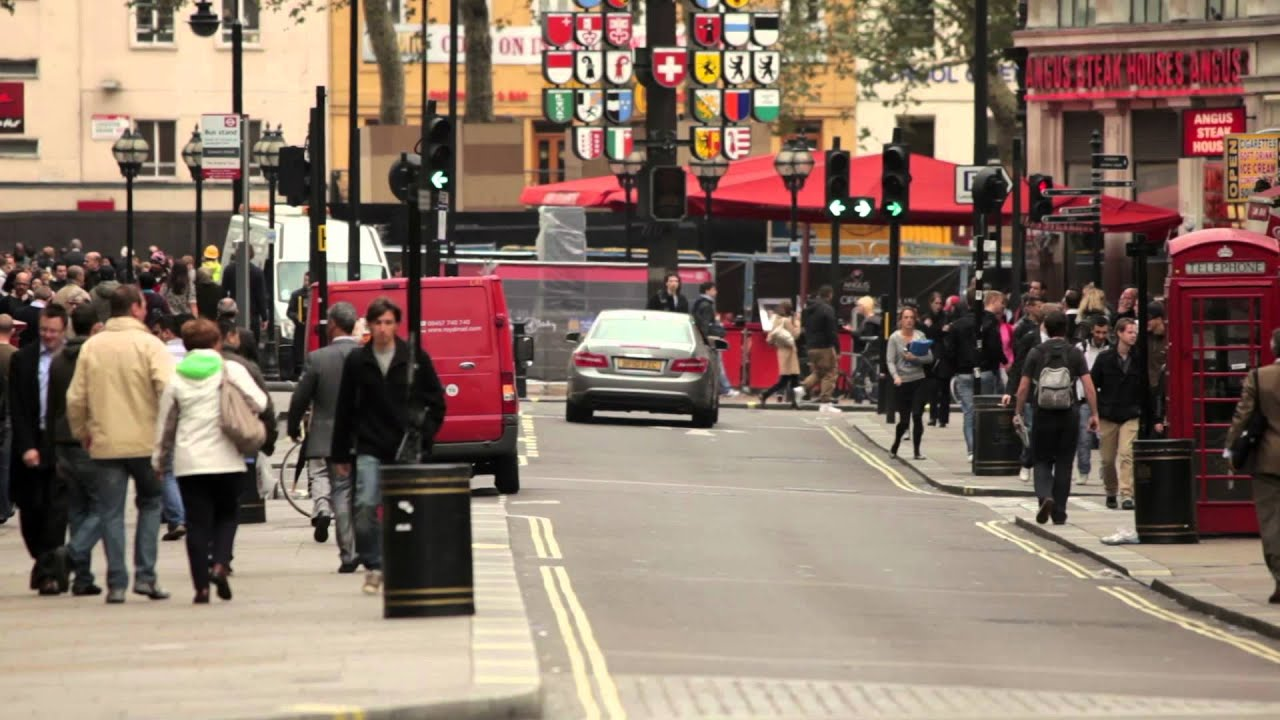

In [5]:
import requests
response = requests.get('https://i.ytimg.com/vi/q71MCWAEfL8/maxresdefault.jpg')
open("obj_det.jpeg", "wb").write(response.content)

img = Image.open("obj_det.jpeg")
img

In [6]:
transform = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224,0.225])])
preprocess_img = transform(img).unsqueeze(0)

In [7]:
import torch
import numpy as np
import time
import os
import csv
import cv2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image


def load_classes(csv_reader):
    result = {}

    for line, row in enumerate(csv_reader):
        line += 1

        try:
            class_name, class_id = row
        except ValueError:
            raise(ValueError('line {}: format should be \'class_name,class_id\''.format(line)))
        class_id = int(class_id)

        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


# Draws a caption above the box in an image
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

def detect_image(image_path, model_path, class_list):

    with open(class_list, 'r') as f:
        classes = load_classes(csv.reader(f, delimiter=','))

    labels = {}
    for key, value in classes.items():
        labels[value] = key

    retinanet = model.resnet50(80)
    retinanet.load_state_dict(torch.load(model_path))

    retinanet.to(device)

    retinanet.training = False
    retinanet.eval()

    for img_name in os.listdir(image_path):

        image = cv2.imread(os.path.join(image_path, img_name))
        if image is None:
            continue
        image_orig = cv2.resize(image.copy(), (640,640))

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        min_side = 608
        max_side = 1024
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        # image = cv2.resize(image, (int(round(cols * scale)), int(round((rows * scale)))))
        image = cv2.resize(image, (640, 640))
        rows, cols, cns = image.shape

        new_image = np.zeros((rows, cols, cns)).astype(np.float32)
        # new_image = np.zeros((640, 640, 3)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)
        image = new_image.astype(np.float32)
        image /= 255
        image -= [0.485, 0.456, 0.406]
        image /= [0.229, 0.224, 0.225]
        image = np.expand_dims(image, 0)
        image = np.transpose(image, (0, 3, 1, 2))

        lbs, bboxes = [], []
        with torch.no_grad():

            image = torch.from_numpy(image)
            image.to(device)

            st = time.time()
            print(image.shape, image_orig.shape, scale)
            scores, classification, transformed_anchors = retinanet(image.to(device).float())
            print('Elapsed time: {}'.format(time.time() - st))
            idxs = np.where(scores.cpu() > 0.5)

            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]

                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = int(bbox[2])
                y2 = int(bbox[3])
                label_name = labels[int(classification[idxs[0][j]])]
                lbs.append(label_name)
                bboxes.append(bbox)
                print(bbox, classification.shape)
                score = scores[j]
                caption = '{} {:.3f}'.format(label_name, score)
                # draw_caption(img, (x1, y1, x2, y2), label_name)
                draw_caption(image_orig, (x1, y1, x2, y2), caption)
                cv2.rectangle(image_orig, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

            return image_orig, lbs, bboxes, retinanet, image

torch.Size([1, 3, 640, 640]) (640, 640, 3) 0.8
Elapsed time: 0.8984847068786621
tensor([138.7579, 274.0210, 209.3851, 501.2363], device='cuda:0') torch.Size([678])
tensor([ 76.1791, 306.4174, 136.2052, 541.7854], device='cuda:0') torch.Size([678])
tensor([504.3512, 293.4076, 548.6282, 464.1378], device='cuda:0') torch.Size([678])
tensor([ 39.0549, 274.5896, 108.9904, 537.4332], device='cuda:0') torch.Size([678])
tensor([442.8152, 290.0496, 474.3910, 402.5984], device='cuda:0') torch.Size([678])
tensor([398.0817, 260.4939, 423.9322, 360.0325], device='cuda:0') torch.Size([678])
tensor([280.7140, 273.8356, 362.6063, 379.2513], device='cuda:0') torch.Size([678])
tensor([515.8860, 319.0759, 540.5635, 364.7939], device='cuda:0') torch.Size([678])


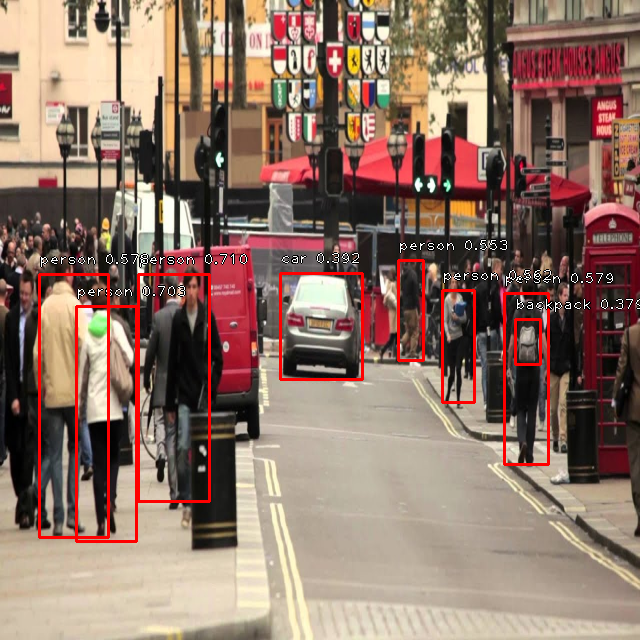

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

img, labels_lst, bbox_lst, retinanet, tensor_test = detect_image("/home/phongtnh/Assigment 4", "/home/phongtnh/Assigment 4/coco_resnet_50_map_0_335_state_dict.pt", "/home/phongtnh/Assigment 4/class_mapping.csv")
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
retinanet 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
for name in retinanet.classificationModel.modules():
    print(name)

ClassificationModel(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (output): Conv2d(256, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (output_act): Sigmoid()
)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU()
Conv2d(256, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Sigmoid()


In [28]:
def pass_to_this_layer(x):
    out = x 
    for _, layer in retinanet.classificationModel.named_children():
        out = layer(out)
        if name == 'output':
            break
    return out


def retinanet_reshape_transform(x): #Compute activations
    acts = [pass_to_this_layer(feat) for feat in x]
    activations = []
    target_size = acts[0].size()[-2 : ]
    for value in acts:
        activations.append(torch.nn.functional.interpolate(value, target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

import torchvision
class RetinanetBBoxScoreTarget: #Define target class for EigenCAM
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        # if model_outputs[2].shape(0) == 0:
        #     return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs[2])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs[1][index] == label:
                score = ious[0, index] + model_outputs[0][index]
                output = output + score
        return output

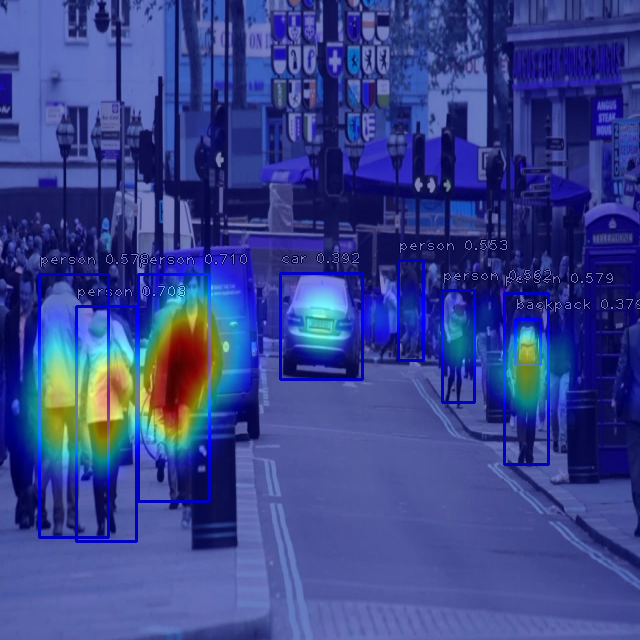

In [29]:
target_layers = [retinanet.fpn]
retinanet.eval()
targets = [RetinanetBBoxScoreTarget(labels=labels_lst, bounding_boxes=bbox_lst)]
cam = EigenCAM(retinanet, 
               target_layers, 
               use_cuda=True, 
               reshape_transform=retinanet_reshape_transform,
               )
grayscale_cam = cam(tensor_test, targets=targets)
grayscale_cam = grayscale_cam[0, :]
image_float_np = np.array(img).astype(np.float32) / 255
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
del grayscale_cam
Image.fromarray(cam_image)

In [30]:
# from collections import OrderedDict
# class AblationLayerRetinaRCNN(AblationLayer):
#     def __init__(self):
#         super(AblationLayerRetinaRCNN, self).__init__()

#         def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
#             """ Extract the next batch member from activations,
#                 and repeat it num_channels_to_ablate times.
#             """
#             self.activations = OrderedDict()
#             for key, value in activations.items():
#                 fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
#                 self.activations[key] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)

#     def __call__(self, x):
#         """ Go over the activation indices to be ablated, stored in self.indices.
#             Map between every activation index to the tensor in the Ordered Dict from the
#             FPN layer.
#         """
#         result = self.activations
#         layers = {}
#         for _, layer in retinanet.fpn.named_children():
#             i = 0
#             layers[i] = layer
#             i += 1
#         num_channels_to_ablate = result[-1].size(0)
#         for i in range(num_channels_to_ablate):
#             pyramid_layer = int(self.indices[i]/256)
#             index_in_pyramid_layer = int(self.indices[i] % 256)
#             result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000
#         return result

In [31]:
# # target_layers = [retinanet.fpn]
# # retinanet.eval()
# # targets = [RetinanetBBoxScoreTarget(labels=labels_lst, bounding_boxes=bbox_lst)]
# # cam = EigenCAM(retinanet, 
# #                target_layers, 
# #                use_cuda=True, 
# #                reshape_transform=retinanet_reshape_transform,
# #                )
# # grayscale_cam = cam(tensor_test, targets=targets)
# # grayscale_cam = grayscale_cam[0, :]
# # image_float_np = np.array(img).astype(np.float32) / 255
# # cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# # del grayscale_cam
# # Image.fromarray(cam_image)

# target_layers = [retinanet.fpn]
# retinanet.eval()
# targets = [RetinanetBBoxScoreTarget(labels=labels_lst, bounding_boxes=bbox_lst)]
# cam = AblationCAM(retinanet,
#                target_layers, 
#                use_cuda=True, 
#                reshape_transform=retinanet_reshape_transform,
#                ablation_layer=AblationLayerRetinaRCNN())

# grayscale_cam = cam(tensor_test, targets=targets)
# Image.fromarray(grayscale_cam)


IndexError: too many indices for tensor of dimension 0